In [1]:
import warnings
warnings.filterwarnings('ignore')
import cv2
from glob import glob
import numpy as np
from numpy import ndarray
import seaborn as sns
from typing import List
import matplotlib.pyplot as plt
from aipose.models.yolov7.domain import YoloV7Pose, YoloV7PoseKeypoints
from sklearn.neighbors import KNeighborsClassifier
from aipose.plot import plot
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

In [2]:
sns.set_theme()

In [3]:
def plot_matrix(cm, classes, title):
  ax = sns.heatmap(cm, cmap="Blues", annot=True, xticklabels=classes, yticklabels=classes, cbar=False)
  ax.set(title=title, xlabel="predicted label", ylabel="true label")

def plot_images(imgs, titles=[], rows=2, columns=2):
    fig = plt.figure(figsize=(20, 10))

    for i, img in enumerate(imgs):
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(img)
        plt.axis('off')
        if i < len(titles):
            plt.title(titles[i])

In [4]:
model = YoloV7Pose()

imgs  = []
predictions = []
for i, path in enumerate(glob('./poses/*.jpg')):
    image: ndarray = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    yolo_v7_keypoints: List[YoloV7PoseKeypoints] = model(image)
    img = plot(image, np.array([value.raw_keypoints for value in yolo_v7_keypoints]), plot_image=False, return_img=True)
    imgs.append(img)
    predictions.append(yolo_v7_keypoints[0])

Using cache found in /home/user/.cache/torch/hub/WongKinYiu_yolov7_main

                 from  n    params  module                                  arguments                     
  0                -1  1         0  models.common.ReOrg                     []                            
  1                -1  1      7040  models.common.Conv                      [12, 64, 3, 1]                
  2                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  3                -1  1      8320  models.common.Conv                      [128, 64, 1, 1]               
  4                -2  1      8320  models.common.Conv                      [128, 64, 1, 1]               
  5                -1  1     36992  models.common.Conv                      [64, 64, 3, 1]                
  6                -1  1     36992  models.common.Conv                      [64, 64, 3, 1]                
  7                -1  1     36992  models.common.Conv                 

In [5]:
X = [prediction.get_points_normalize_by_bbox() for prediction in predictions]

In [6]:
y = ['Sit', 'Other', 'Sit', 'Other', 'Other', 'Other', 'Other', 'Sit', 'Other', 'Other', 'Other', 'Sit', 'Sit', 'Other', 'Other', 'Sit', 'Other', 'Other', ]

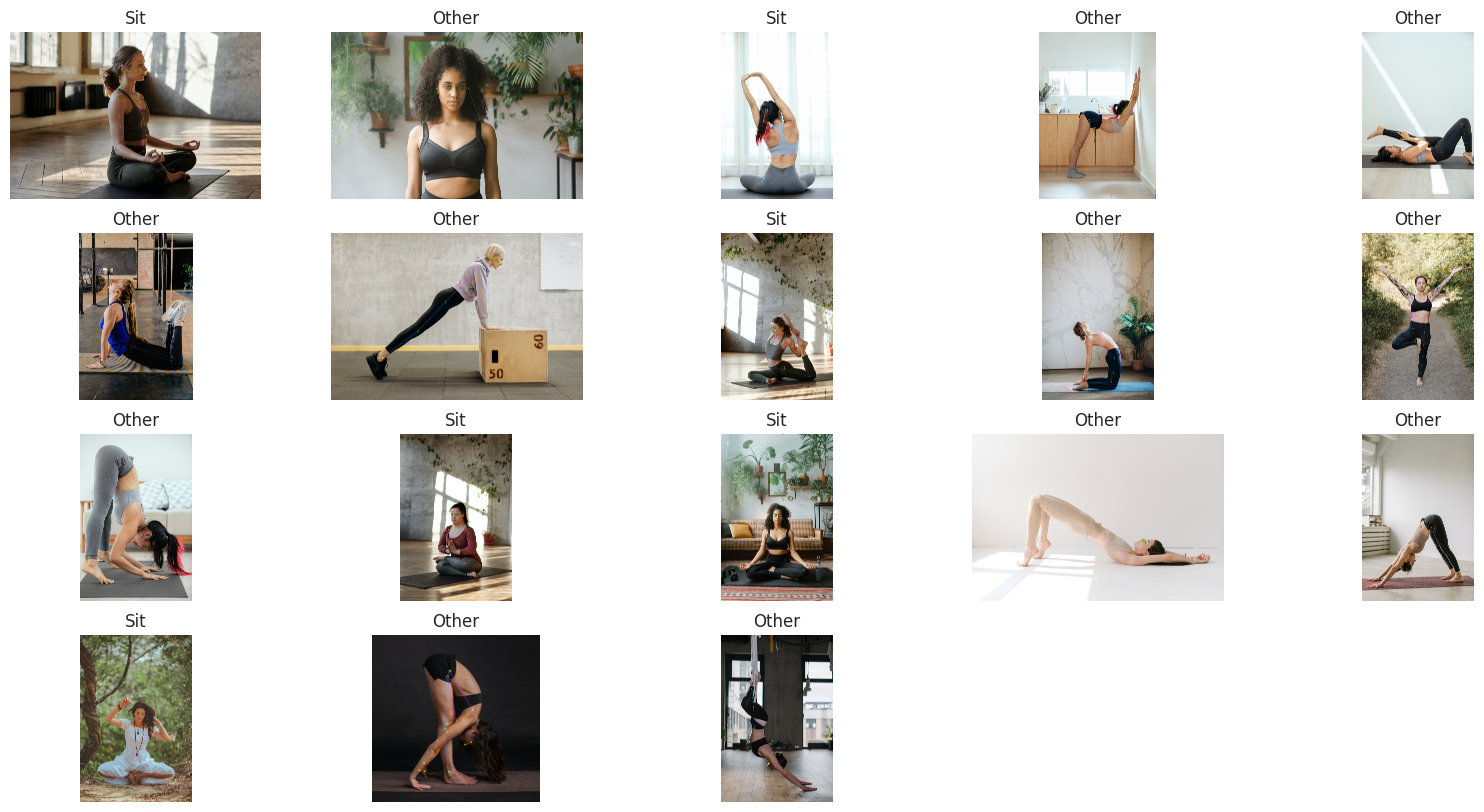

In [7]:
%matplotlib inline
plot_images(imgs, titles=y, rows=4, columns=5)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [9]:
parameters = {'n_neighbors':[1, 2]}
neigh = KNeighborsClassifier()
clf = GridSearchCV(neigh, parameters)
clf.fit(X_train, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2]})

In [10]:
predictions_knn = clf.predict([prediction.get_points_normalize_by_bbox() for prediction in predictions])

In [11]:
predictions_knn

array(['Sit', 'Sit', 'Sit', 'Other', 'Other', 'Sit', 'Other', 'Sit', 'Sit', 'Other', 'Other', 'Sit', 'Sit', 'Other', 'Other', 'Sit', 'Other', 'Other'], dtype='<U5')

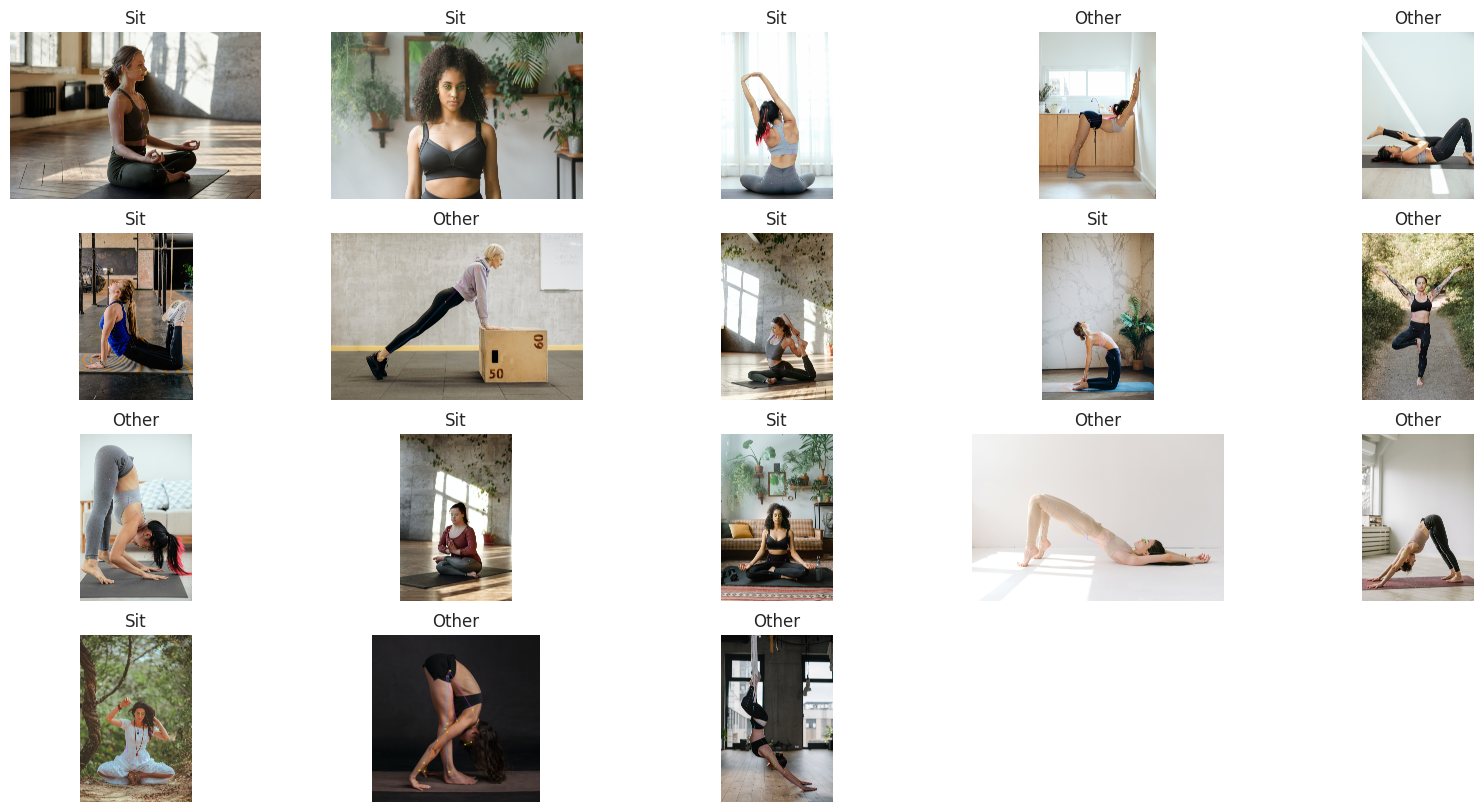

In [12]:
%matplotlib inline
plot_images(imgs, titles=predictions_knn, rows=4, columns=5)

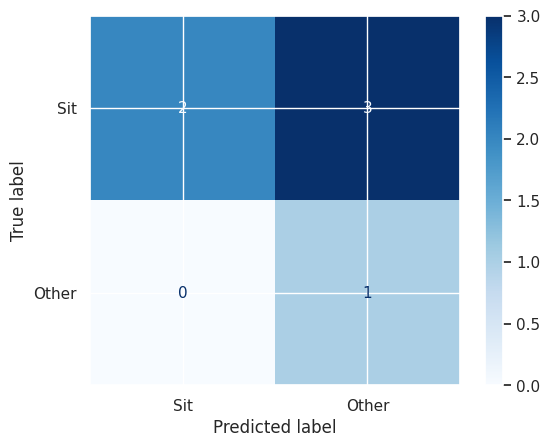

In [13]:
ConfusionMatrixDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        display_labels=['Sit', 'Other'],
        cmap=plt.cm.Blues
)

In [14]:
X_test, y_train, y_test
y_pred = clf.predict(X_test)
y_true = y_test
accuracy_score(y_true, y_pred)
accuracy_score(y_true, y_pred, normalize=True)

0.5